<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/Baseline_Classification_split_50_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline Models for CICIDS 2017 Data Set with 71 Features

We use the pre-processing dataset from mlp4nids (Multi-layer perceptron for network intrusion detection) https://github.com/ArnaudRosay/mlp4nids. The dataset is splitted into 50:25:25.  We use the following classification methods: PCA+RF,Naive Bayes model, Decision Tree Classifier, Random Foresty with DecisionTree, Logistic Regression Classifier, Adaboost, Voting, kNN, and DNN. 

In [1]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def display_metrics(y_test, y_pred, label_names):
  print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

  print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
  print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
  print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

  print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
  print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
  print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

  print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
  print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
  print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

  print('\nClassification Report\n')
  print(classification_report(y_test, y_pred, target_names=label_names))

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        print(df)

In [4]:
def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d

In [5]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

## Step 1. Loading csv files

In [6]:
# All columns
col_names = ['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min', 'Label']

### Option 1. Connect to Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# load three csv files generated by mlp4nids (Multi-layer perceptron for network intrusion detection )
# first load the train set
df_train = pd.read_csv('/content/drive/My Drive/CICIDS2017/train_set.csv',names=col_names, skiprows=1)  

In [9]:
print('Train set size: ', df_train.shape)

Train set size:  (556548, 72)


In [10]:
df_test = pd.read_csv('/content/drive/My Drive/CICIDS2017/test_set.csv',names=col_names, skiprows=1)  
print('Test set size: ', df_test.shape)

df_val = pd.read_csv('/content/drive/My Drive/CICIDS2017/crossval_set.csv',names=col_names, skiprows=1)  
print('Validation set size: ', df_val.shape)

Test set size:  (278271, 72)
Validation set size:  (278271, 72)


### Option 2. Load from local machine

In [ ]:
dataroot = '../data/cicids2017clean/train_set.csv'
df_train = pd.read_csv(dataroot, names=col_names, skiprows=1) 

In [ ]:
dataroot = '../data/cicids2017clean/crossval_set.csv'
df_val = pd.read_csv(dataroot, names=col_names, skiprows=1) 
dataroot = '../data/cicids2017clean/test_set.csv'
df_test = pd.read_csv(dataroot, names=col_names, skiprows=1) 

## Step 2. Exploring the dataset

In [11]:
df_train.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
546863,50203,389,17,130,2,2,328,326,164,164,164.0,0.000000,163,163,163.000000,0.000000,5.030769e+06,30769.230770,4.333333e+01,6.812733e+01,122,4,4,4.000000e+00,0.0,4,4,4,4.000,0.000000e+00,4,4,0,0,40,40,15384.615380,15384.615380,163,164,163.600000,0.547723,3.000000e-01,0,0,0,0,0,0,0,0,1,204.500000,164.0,163.000000,2,328,2,326,-1,-1,1,20,0.0,0.0000,0,0,0.0,0.0000,0,0,BENIGN
2284286,47786,80,6,85594954,6,6,360,11595,360,0,60.0,146.969385,4344,0,1932.500000,1754.831473,1.396694e+02,0.140195,7.781359e+06,2.580000e+07,85500000,4,85500000,1.710000e+07,38200000.0,85500000,4,144398,28879.600,5.847893e+04,133148,16,0,0,200,200,0.070098,0.070098,0,4344,919.615385,1498.335273,2.245009e+06,0,0,0,0,1,0,0,0,1,996.250000,60.0,1932.500000,6,360,6,11595,251,235,1,32,495.0,0.0000,495,495,85500000.0,0.0000,85500000,85500000,DoS Hulk
390020,51520,443,6,117915594,19,17,1406,4654,774,0,74.0,179.202245,1418,0,273.764706,485.037567,5.139269e+01,0.305303,3.369017e+06,1.380000e+07,58900000,1,118000000,6.550866e+06,18900000.0,58900000,1,118000000,7366629.625,2.000000e+07,59000000,1,0,0,616,552,0.161132,0.144171,0,1418,163.783784,362.393290,1.313289e+05,0,0,0,1,0,0,0,0,0,168.333333,74.0,273.764706,19,1406,17,4654,29200,181,8,32,495327.0,572653.2552,900254,90400,58400000.0,665473.7481,58900000,58000000,BENIGN
212934,61397,53,17,30731,1,1,46,93,46,46,46.0,0.000000,93,93,93.000000,0.000000,4.523120e+03,65.080863,3.073100e+04,0.000000e+00,30731,30731,0,0.000000e+00,0.0,0,0,0,0.000,0.000000e+00,0,0,0,0,20,20,32.540431,32.540431,46,93,61.666667,27.135463,7.363333e+02,0,0,0,0,0,0,0,0,1,92.500000,46.0,93.000000,1,46,1,93,-1,-1,0,20,0.0,0.0000,0,0,0.0,0.0000,0,0,BENIGN
306030,80,37209,6,49,1,1,0,0,0,0,0.0,0.000000,0,0,0.000000,0.000000,0.000000e+00,40816.326530,4.900000e+01,0.000000e+00,49,49,0,0.000000e+00,0.0,0,0,0,0.000,0.000000e+00,0,0,0,0,32,32,20408.163270,20408.163270,0,0,0.000000,0.000000,0.000000e+00,0,0,0,0,1,1,0,0,1,0.000000,0.0,0.000000,1,0,1,0,332,229,0,32,0.0,0.0000,0,0,0.0,0.0000,0,0,BENIGN


Count the number of attacks

In [12]:
df_train['Label'].value_counts()

BENIGN                        278274
DoS Hulk                      115062
PortScan                       79402
DDoS                           64012
DoS GoldenEye                   5146
FTP-Patator                     3967
SSH-Patator                     2948
DoS slowloris                   2898
DoS Slowhttptest                2749
Bot                              978
Web Attack � Brute Force         753
Web Attack � XSS                 326
Infiltration                      18
Web Attack � Sql Injection        10
Heartbleed                         5
Name: Label, dtype: int64

Read test and validation sets

In [13]:
print('Test set: ')
df_test['Label'].value_counts()

Test set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack � Brute Force         376
Web Attack � XSS                 163
Infiltration                       9
Web Attack � Sql Injection         5
Heartbleed                         3
Name: Label, dtype: int64

In [14]:
print('Validation set: ')
df_val['Label'].value_counts()

Validation set: 


BENIGN                        139135
DoS Hulk                       57531
PortScan                       39701
DDoS                           32006
DoS GoldenEye                   2573
FTP-Patator                     1983
SSH-Patator                     1474
DoS slowloris                   1449
DoS Slowhttptest                1374
Bot                              489
Web Attack � Brute Force         376
Web Attack � XSS                 163
Infiltration                       9
Web Attack � Sql Injection         5
Heartbleed                         3
Name: Label, dtype: int64

## Step 3. Encode Datasets

Encoding the labels, and generate numpy array. Note that the label has not been encoded as one-hot coding. We will use one-hot code later. 

### Step 3.1 Encoding train dataset

In [15]:
df_label = df_train['Label']
data = df_train.drop(columns=['Label'])
Xtrain = data.values
y_train = encode_label(df_label.values)

### Step 3.2. Encoding test dataset

In [16]:
df_label = df_test['Label']
data = df_test.drop(columns=['Label'])
Xtest = data.values
y_test = encode_label(df_label.values)

### Step 3.3 Encoding validation dataset

In [17]:
df_label = df_val['Label']
data = df_val.drop(columns=['Label'])
Xval = data.values
y_val = encode_label(df_label.values)

## Step 4. Normalization or Standardization

The continuous feature values are normalized into the same feature space. This is important when using features that have different measurements, and is a general requirement of many machine learning algorithms. We implement the two methods to see the impact on the final classifications. 

## Option 1. Normalization

The values of the datasets are normalized using the Min-Max scaling technique, bringing them all within a range of [0,1].

### Step 4.1 Normalizing train dataset

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtrain)
X_train

array([[7.66048676e-01, 5.93603125e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.29167620e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 7.12500000e-01, 7.12500000e-01],
       [7.86144808e-01, 6.76005616e-03, 3.52941176e-01, ...,
        8.96864890e-03, 4.90833333e-01, 4.83333333e-01],
       ...,
       [2.53009842e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.85610742e-01, 8.08765183e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.26276036e-01, 1.22077764e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 4.2. Normalizing validation dataset

In [ ]:
X_val = scaler.fit_transform(Xval)
X_val

array([[4.37994965e-01, 1.22344737e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.41290913e-01, 6.12488339e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87327382e-02, 6.77483980e-03, 3.52941176e-01, ...,
        5.68691207e-05, 8.33333333e-02, 8.32947583e-02],
       ...,
       [9.30510414e-01, 8.10533882e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.50492103e-01, 8.68494701e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.24353399e-01, 1.22344737e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Step 4.3. Normalizing test dataset

In [ ]:
X_test = scaler.fit_transform(Xtest)
X_test

array([[5.45487838e-01, 9.66383862e-01, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.17142247e-01, 1.22074038e-03, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.92001099e-01, 7.97448653e-02, 3.52941176e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.04507584e-01, 1.22074038e-03, 3.52941176e-01, ...,
        0.00000000e+00, 8.33370661e-01, 8.33370661e-01],
       [9.22345653e-01, 8.08740501e-04, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.45030061e-01, 6.75984985e-03, 3.52941176e-01, ...,
        5.01804492e-03, 4.88761059e-01, 4.84412289e-01]])

## Option 2. Standardization

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

X_train = scaler.fit_transform(Xtrain)
X_val = scaler.fit_transform(Xval)
X_test = scaler.fit_transform(Xtest)

X_train

array([[ 0.44038783, -0.39965161,  1.91238948, ..., -0.16609924,
        -0.51046627, -0.47636976],
       [ 0.32397456, -0.41782911, -0.5219767 , ..., -0.16609924,
         2.01162882,  2.14691177],
       [ 0.50382029, -0.39647496, -0.5219767 , ..., -0.07444588,
         1.22697701,  1.30316625],
       ...,
       [-1.17899436, -0.41782911, -0.5219767 , ..., -0.16609924,
        -0.51046627, -0.47636976],
       [ 0.50213454, -0.41941743,  1.91238948, ..., -0.16609924,
        -0.51046627, -0.47636976],
       [ 0.63049256, -0.41782911, -0.5219767 , ..., -0.16609924,
        -0.51046627, -0.47636976]])

## Step 5 One-hot encoding for labels

y_train, y_test and y_val have to be one-hot-encoded. That means they must have dimension (number_of_samples, 15), where 15 denotes number of classes.

In [20]:
from tensorflow.keras.utils import to_categorical

Save the labels for AdaBoostClassifier

In [21]:
y_train_ada = y_train
y_test_ada = y_test
y_val_ada = y_val

In [22]:
y_train = to_categorical(y_train, 15)
y_test = to_categorical(y_test, 15)
y_val = to_categorical(y_val, 15)

## Step 6. Define the metrics

In [23]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier

#importing confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn import metrics
from sklearn.metrics import accuracy_score

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [78]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

#  Model 1: PCA  

In [24]:
X_pca = df_train.drop('Label',axis=1)
y_pca = df_train['Label']

In [27]:
scaler = MinMaxScaler()
X_pca = scaler.fit_transform(X_pca)

In [28]:
dfx = pd.DataFrame(data=X_pca,columns=df_train.columns[1:])

In [29]:
dfx.head(10)

,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.766049,0.005936,1.000000,1.191667e-06,0.000005,0.000007,0.000114,5.199362e-07,0.006608,0.111413,0.027605,0.000000,0.009381,0.111644,0.037294,0.000000,0.087508,0.406154,4.694444e-07,8.033883e-07,1.125000e-06,1.416667e-07,3.333333e-08,3.333333e-08,0.000000,3.333333e-08,1.333333e-07,3.333333e-08,3.333333e-08,0.000000,3.333333e-08,3.333333e-08,0.0,0.0,0.000009,0.000007,5.128205e-03,7.692308e-03,0.119941,0.006608,0.084468,0.000116,1.339286e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008065,0.080894,0.027605,0.037294,0.000005,0.000114,0.000007,5.199035e-07,0.000000,0.000000,0.000005,0.333333,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,0.729168,0.001221,0.352941,7.132916e-01,0.000024,0.000021,0.000126,1.849282e-05,0.014504,0.000000,0.010100,0.020848,0.250000,0.000000,0.442150,0.262135,0.085285,0.400000,6.484476e-02,3.042453e-01,7.125000e-01,1.416667e-07,7.125000e-01,1.425000e-01,0.458034,7.125000e-01,1.333333e-07,1.203317e-03,2.406633e-04,0.000719,1.109567e-03,1.333333e-07,0.0,0.0,0.000046,0.000035,2.336586e-08,3.504879e-08,0.000000,0.175020,0.474804,0.316671,1.002236e-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.008065,0.394086,0.010100,0.442150,0.000024,0.000126,0.000021,1.849166e-05,0.003845,0.003601,0.000005,0.533333,4.500000e-06,0.000000,4.500000e-06,4.500000e-06,0.712500,0.000000,0.712500,0.712500
2,0.786145,0.006760,0.352941,9.826304e-01,0.000087,0.000060,0.000491,7.422648e-06,0.031185,0.000000,0.012456,0.025421,0.081607,0.000000,0.062637,0.072454,0.085285,0.400000,2.807525e-02,1.627358e-01,4.908334e-01,1.166667e-07,9.833333e-01,5.459055e-02,0.226619,4.908333e-01,1.083333e-07,9.833333e-01,6.138858e-02,0.246002,4.916667e-01,8.333333e-09,0.0,0.0,0.000141,0.000097,5.371074e-08,7.208546e-08,0.000000,0.057131,0.084563,0.076591,5.862897e-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.066588,0.012456,0.062637,0.000087,0.000491,0.000060,7.422180e-06,0.445572,0.002777,0.000040,0.533333,4.502973e-03,0.008123,8.184127e-03,8.218182e-04,0.486667,0.008969,0.490833,0.483333
3,0.936858,0.000809,1.000000,2.562001e-04,0.000000,0.000004,0.000016,1.483254e-07,0.001853,0.031250,0.007743,0.000000,0.005352,0.063699,0.021278,0.000000,0.085287,0.400013,2.562000e-04,0.000000e+00,2.562000e-04,2.562000e-04,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,9.999999e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000005,0.000004,1.084681e-05,1.627022e-05,0.033848,0.003747,0.031839,0.005735,3.287202e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008065,0.036590,0.007743,0.021278,0.000000,0.000016,0.000004,1.483160e-07,0.000000,0.000000,0.000000,0.333333,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,0.001221,0.567799,0.352941,5.166668e-07,0.000000,0.000004,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [30]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components=None)

In [32]:
dfx_pca = pca.fit(dfx)

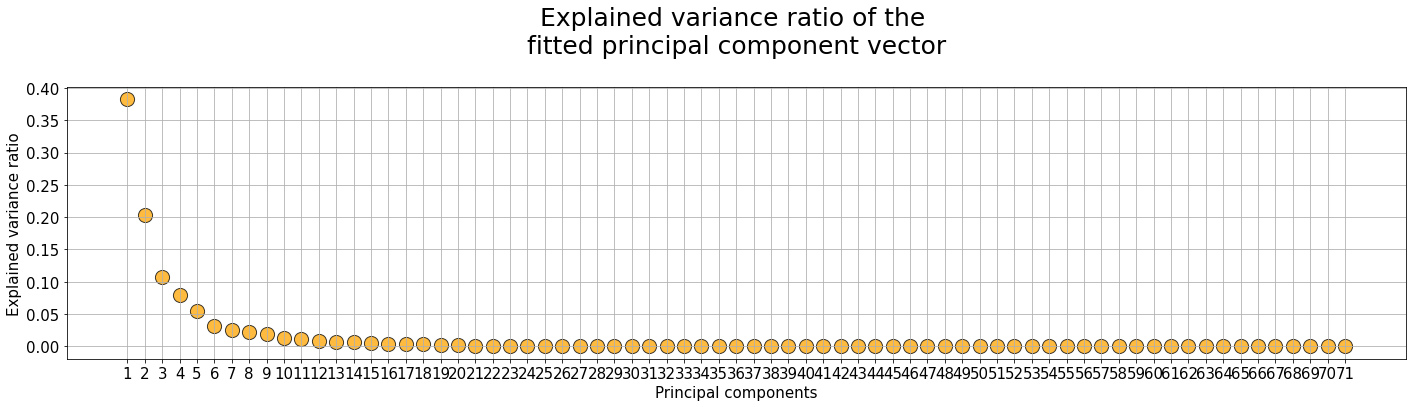

In [33]:
plt.figure(figsize=(24,5))
plt.scatter(x=[i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],
            y=dfx_pca.explained_variance_ratio_,
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(dfx_pca.explained_variance_ratio_))],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

The above two plots means that the $1^{st}$ principal component explains about 38% of the total variance in the data and the $2^{nd}$ component explians further 20%. Therefore, if we just consider first two components, they together explain 58% of the total variance. Using the first 10 features should give very hight detection rate.

Transform the scaled data set using the fitted PCA object

In [34]:
dfx_trans = pca.transform(dfx)

Put it in a data frame

In [35]:
dfx_trans = pd.DataFrame(data=dfx_trans)
dfx_trans.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,-0.528423,-0.054268,-0.650975,-0.121440,0.312771,-0.020526,0.162312,0.045466,0.016224,0.018418,-0.016460,-0.009318,-0.029015,-0.037342,0.054113,0.022644,-0.034882,-0.064366,0.059290,0.067341,0.008456,0.005647,-0.016734,-0.009924,0.011498,0.040912,-0.002341,-0.006321,0.005452,-0.001471,-0.004027,-0.001112,-0.004714,0.001864,-0.017931,0.061893,-0.026181,0.042581,0.001005,0.003243,-0.012712,-0.004542,0.003541,0.003650,0.000704,0.001703,0.001483,-0.004438,-0.003796,0.000328,-0.003189,-0.000144,0.000063,0.000049,0.000009,-2.176527e-06,1.611283e-05,-0.000018,-0.000002,4.041820e-06,-1.238171e-06,-2.748805e-08,-1.509605e-14,-2.228795e-17,-8.503432e-18,1.625856e-17,-1.218493e-17,-4.179102e-17,-2.199646e-17,9.685354e-17,-1.851814e-18
1,1.739488,-0.212510,0.025645,-0.445235,-0.287995,-0.163435,0.206944,-0.119024,-0.104394,-0.022308,0.020001,-0.035603,-0.030896,-0.109088,-0.012269,-0.034573,0.009246,-0.110195,-0.106397,-0.012228,-0.019110,0.059648,-0.018026,0.005633,0.010983,-0.019082,-0.023557,-0.014568,0.003716,-0.009144,0.005187,0.002976,0.008936,0.004616,0.002021,0.002431,-0.000896,-0.001479,-0.002188,0.004361,0.003698,0.001344,0.000228,0.002848,-0.000120,0.000680,0.000603,-0.001401,-0.001029,0.000068,0.001740,-0.001242,-0.000199,0.000195,0.000028,-4.146829e-05,1.448086e-05,-0.000019,0.000005,-2.261037e-06,3.311790e-07,3.997343e-08,1.356087e-14,9.996802e-17,-9.803726e-17,-1.711226e-16,5.436059e-18,-6.359054e-17,1.297594e-16,2.321866e-17,2.516472e-18
2,1.045422,0.851608,-0.133830,1.096464,-0.612687,-0.005037,0.194180,0.308140,0.292880,-0.059210,0.134051,-0.069702,0.107466,-0.122517,-0.163518,0.133958,-0.021142,0.009501,0.041338,0.024245,0.041956,-0.049701,0.029794,-0.075642,0.011467,-0.001007,-0.017069,-0.045927,-0.012788,0.018669,-0.006433,-0.001649,-0.004328,-0.007064,-0.012518,-0.005144,0.000620,0.008119,-0.001088,-0.006066,0.006021,0.005828,0.000993,-0.003935,0.007716,0.000583,-0.002909,-0.002198,0.004929,-0.000091,0.005610,0.001013,-0.003497,0.002445,0.000067,-9.018644e-07,-4.730441e-07,0.000025,0.000020,-4.214114e-06,1.546327e-06,1.943857e-08,1.052508e-14,1.038516e-16,-3.633533e-17,2.367270e-17,3.136584e-17,2.701720e-17,6.242877e-17,-3.407114e-16,4.723279e-20
3,-0.543423,-0.031737,-0.731471,-0.147769,0.220560,-0.020285,0.113929,0.128449,-0.049466,0.060202,-0.018380,-0.026028,-0.000234,-0.018275,0.051521,0.042006,-0.033595,-0.020154,0.068244,-0.009795,0.009078,0.001913,0.004309,-0.004630,-0.008054,-0.009773,0.000802,0.001302,-0.002100,-0.002422,0.001251,-0.000305,-0.001417,0.000812,-0.000841,0.002127,-0.001180,0.002067,-0.000559,0.000378,-0.000283,0.000512,0.000027,0.001010,-0.000678,-0.000625,-0.000242,0.001190,0.001176,-0.000129,0.002343,-0.000029,0.000074,-0.000033,-0.000093,-1.917587e-05,-5.732972e-06,0.000016,-0.000008,2.466251e-06,-2.183444e-06,-2.336814e-09,3.831866e-15,-1.297701e-17,-1.395204e-17,-3.735473e-17,-1.202928e-17,-5.280530e-17,-2.172905e-17,7.176566e-17,-2.290972e-18
4,-0.339273,-1.189368,0.601774,0.283416,0.291701,-0.319752,-0.086461,0.136513,-0.095492,-0.262394,-0.048651,-0.068839,0.064652,0.020744,-0.102028,-0.081915,0.011500,0.032993,-0.088276,-0.042493,-0.013505,0.008438,0.000658,-0.001501,-0.001269,0.001470,0.010144,-0.006001,0.001307,-0.005995,0.000620,-0.002780,-0.012747,0.000592,-0.002630,-0.002152,0.001322,-0.000360,0.000594,-0.001753,0.000559,0.000323,-0.000689,-0.010333,0.001079,0.000086,-0.000114,0.000334,0.000538,-0.000046,-0.000515,0.000276,-0.000179,0.000051,0.000134,2.666180e-05,5.584027e-06,-0.000007,-0.000003,3.646325e-07,1.228497e-06,-3.250384e-08,-5.747088e-16,-3.200169e-17,1.036441e-16,-3.193941e-17,1.613148e-17,-2.365744e-16,-2.654429e-17,6.107156e-17,-3.736141e-19
5,2.027563,0.074277,0.313869,-0.927671,0.064372,-0.080116,0.149591,0.047926,0.005484,-0.032374,-0.021931,-0.060036,0.162083,

## Training and Making Predictions

In this case we'll use random forest classification for making the predictions.

In [36]:
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [37]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train_pca, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test_pca)

In [38]:
print('Accuracy:%f' %accuracy_score(y_test, y_pred))
print("Precision:%f" %metrics.average_precision_score(y_test, y_pred, average='weighted'))
print("Recall:%f" %metrics.recall_score(y_test, y_pred, average='weighted'))
print("F1-score:%f" %metrics.f1_score(y_test, y_pred,average='weighted'))

Accuracy:0.514412
Precision:0.586086
Recall:0.514412
F1-score:0.607775


In [ ]:
#The confusion matrix takes a vector of labels (not the one-hot encoding). 


cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

[[138946      0      0      0      0      0      0      0      0      0
     189      0      0      0      0]
 [   489      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 31990      0      0      0      0      0      0      0      0      0
      16      0      0      0      0]
 [  2573      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [ 57531      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [  1373      0      0      0      0      0      0      0      0      0
       1      0      0      0      0]
 [  1444      0      0      0      0      0      0      0      0      0
       5      0      0      0      0]
 [  1983      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     2      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     9  

Get the attacks' names

In [39]:
labels_d = make_value2index(df_test['Label'])

In [40]:
print(labels_d)

{'BENIGN': 139134, 'Bot': 139623, 'DDoS': 171629, 'DoS GoldenEye': 174202, 'DoS Hulk': 231733, 'DoS Slowhttptest': 233107, 'DoS slowloris': 234556, 'FTP-Patator': 236539, 'Heartbleed': 236542, 'Infiltration': 236551, 'PortScan': 276252, 'SSH-Patator': 277726, 'Web Attack � Brute Force': 278102, 'Web Attack � Sql Injection': 278107, 'Web Attack � XSS': 278270}


In [41]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels_d))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.59      1.00      0.75    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.00      0.00      0.00      2573
                  DoS Hulk       0.86      0.44      0.58     57531
          DoS Slowhttptest       0.00      0.00      0.00      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       1.00      0.38      0.55     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model : Naive Bayes model (GaussianNB)

In [42]:
from sklearn.naive_bayes import GaussianNB

In [43]:
model_gaussian = GaussianNB()
model_gaussian.fit(X_train, y_train_ada)

GaussianNB(priors=None, var_smoothing=1e-09)

In [44]:
# make predictions
y_pred = model_gaussian.predict(X_test)

In [45]:
display_metrics(y_test_ada, y_pred, labels_d)


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.03
Macro Recall: 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.04

Weighted Precision: 0.25
Weighted Recall: 0.50
Weighted F1-score: 0.33

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.50      1.00      0.67    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.00      0.00      0.00      2573
                  DoS Hulk       0.00      0.00      0.00     57531
          DoS Slowhttptest       0.00      0.00      0.00      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.00      0.00      0.00     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 3: Decision Tree Classifier

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
model_dec = DecisionTreeClassifier()
model_dec.fit(X_train, y_train_ada)
y_pred = model_dec.predict(X_test)

In [48]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_ada, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_ada, y_pred, average='weighted')))
 
print('\nClassification Report\n')

print(classification_report(y_test_ada , y_pred, target_names=labels_d))


Accuracy: 0.48

Micro Precision: 0.48
Micro Recall: 0.48
Micro F1-score: 0.48

Macro Precision: 0.22
Macro Recall: 0.16


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.15

Weighted Precision: 0.35
Weighted Recall: 0.48
Weighted F1-score: 0.39

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.60      0.93      0.73    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.21      0.23      0.22      2573
                  DoS Hulk       0.00      0.00      0.00     57531
          DoS Slowhttptest       0.55      0.15      0.23      1374
             DoS slowloris       0.99      0.07      0.13      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.60      1.00      0.75         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.29      0.10      0.15     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 4: Random Foresty with DecisionTree

In [49]:
clf = RandomForestClassifier(n_estimators=10, random_state=10)
clf.fit(X_train,y_train)
    
y_pred = clf.predict(X_test)

In [53]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_ada, np.argmax(y_pred, axis = 1))))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_ada, np.argmax(y_pred, axis = 1), average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_ada, np.argmax(y_pred, axis = 1), average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, np.argmax(y_pred, axis = 1), average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_ada, np.argmax(y_pred, axis = 1), average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_ada, np.argmax(y_pred, axis = 1), average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, np.argmax(y_pred, axis = 1), average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_ada, np.argmax(y_pred, axis = 1), average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_ada, np.argmax(y_pred, axis = 1), average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_ada, np.argmax(y_pred, axis = 1), average='weighted')))
 
print('\nClassification Report\n')

print(classification_report(y_test_ada ,np.argmax(y_pred, axis = 1), target_names=labels_d))


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.10
Macro Recall: 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.05

Weighted Precision: 0.46
Weighted Recall: 0.50
Weighted F1-score: 0.34

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.50      1.00      0.67    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.00      0.00      0.00      2573
                  DoS Hulk       1.00      0.01      0.02     57531
          DoS Slowhttptest       0.00      0.00      0.00      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.00      0.00      0.00     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 5: Logistic Regression Classifier

In [54]:
from sklearn import linear_model

In [55]:
attack_classifier = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
attack_classifier.fit(X_train, y_train_ada)

y_pred = attack_classifier.predict(X_test)

In [56]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_ada, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_ada, y_pred, average='weighted')))
 
print('\nClassification Report\n')

print(classification_report(y_test_ada , y_pred, target_names=labels_d))


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.34
Macro Recall: 0.39
Macro F1-score: 0.32

Weighted Precision: 0.86
Weighted Recall: 0.82
Weighted F1-score: 0.83

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.90      0.85      0.88    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.62      1.00      0.76     32006
             DoS GoldenEye       0.33      0.20      0.25      2573
                  DoS Hulk       0.92      0.63      0.75     57531
          DoS Slowhttptest       0.13      0.07      0.09      1374
             DoS slowloris       0.35      0.36      0.36      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.96      1.00      0.98     39701
               SSH-Patator       0.79      0.50      0.62      1474
  Web Attack � Brute Force       0.07      0.40      0.11       376
Web Attack � Sql Injection       0.00      0.80

# Model 6: AdaBoostClassifier

In [57]:
from sklearn.ensemble import AdaBoostClassifier

In [58]:
model_ada = AdaBoostClassifier(n_estimators=100)
model_ada.fit(X_train, y_train_ada)

# make predictions
expected = y_test_ada
predicted = model_ada.predict(X_test)

In [59]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_ada, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_ada, y_pred, average='weighted')))
 
print('\nClassification Report\n')


Accuracy: 0.82

Micro Precision: 0.82
Micro Recall: 0.82
Micro F1-score: 0.82



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.34
Macro Recall: 0.39
Macro F1-score: 0.32

Weighted Precision: 0.86
Weighted Recall: 0.82
Weighted F1-score: 0.83

Classification Report



In [60]:
print(classification_report(y_test_ada, predicted, target_names=labels_d))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.60      0.99      0.75    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.00      0.00      0.00      2573
                  DoS Hulk       0.58      0.48      0.52     57531
          DoS Slowhttptest       0.00      0.00      0.00      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      1.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.00      0.00      0.00     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 6: XGBClassifier (very slow)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgboostc = XGBClassifier(learning_rate = 0.1, max_depth = 5,n_estimators = 1165, subsample=0.8,colsample_bytree=0.8,seed=27)
xgboostc.fit(X_train,y_train)
    
y_pred = xgboostc.predict(X_test)

KeyboardInterrupt: ignored

In [ ]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_ada, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_ada, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_ada, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_ada, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_ada, y_pred, average='weighted')))
 
print('\nClassification Report\n')

# Model 7: Voting 

In [61]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

In [63]:
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=35, criterion="entropy")
ada = AdaBoostClassifier(n_estimators=75, learning_rate=1.5)
etc = ExtraTreesClassifier(n_jobs=-1, criterion="entropy", n_estimators=5)
eclf = VotingClassifier(estimators=[('ada', ada), ('rfc', rfc), ('etc', etc)], voting='soft', weights=[2, 1, 3],n_jobs=1)
eclf.fit(X_train,y_train_ada)

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=None,
                                                 learning_rate=1.5,
                                                 n_estimators=75,
                                                 random_state=None)),
                             ('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
           

In [64]:
y_pred = eclf.predict(X_test)

In [65]:
display_metrics(y_test_ada, y_pred,labels_d)


Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.36
Macro Recall: 0.19


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.20

Weighted Precision: 0.60
Weighted Recall: 0.61
Weighted F1-score: 0.52

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.56      1.00      0.72    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       1.00      0.42      0.59     32006
             DoS GoldenEye       0.94      0.08      0.14      2573
                  DoS Hulk       0.90      0.28      0.43     57531
          DoS Slowhttptest       0.97      0.05      0.09      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       1.00      1.00      1.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.00      0.00      0.00     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 8: KNN Model

In [66]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
features_order = ['Source Port', 'Destination Port',
                      'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets',
                      'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean',
                      'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
                      'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
                      'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
                      'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
                      'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
                      'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                      'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Fwd Segment Size',
                      'Avg Bwd Segment Size','Subflow Fwd Packets', 'Subflow Fwd Bytes',
                      'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
                      'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
                      'Idle Std', 'Idle Max', 'Idle Min']

In [69]:
features=["Fwd Packet Length Max","Flow IAT Std","Fwd Packet Length Std" ,"Fwd IAT Total",'Flow Packets/s', "Fwd Packet Length Mean",  "Flow Bytes/s",  "Flow IAT Mean", "Bwd Packet Length Mean",  "Flow IAT Max", "Bwd Packet Length Std", ]

In [70]:
df_knn_train = pd.DataFrame(X_train, columns = features_order)
df_knn_train.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.440388,-0.399652,1.912389,-0.564734,-0.008664,-0.007233,-0.043168,-0.006377,-0.138669,1.352672,0.202439,-0.246600,-0.539960,2.376337,-0.456260,-0.561373,0.184633,-0.147382,-0.381429,-0.520573,-0.523283,-0.055856,-0.551962,-0.397978,-0.490145,-0.512693,-0.103626,-0.366432,-0.238771,-0.299101,-0.321189,-0.098360,-0.19009,0.0,-0.010990,-0.009186,-0.182966,0.179785,6.971585,-0.586699,-0.332459,-0.641775,-0.481515,-0.244129,-0.19009,-0.01089,-0.750640,-0.769272,-0.320901,0.0,-0.01089,0.184487,-0.284095,0.202439,-0.456260,-0.008664,-0.043168,-0.007233,-0.006376,-0.506005,-0.175389,-0.006338,-0.863266,-0.151069,-0.090907,-0.163927,-0.132944,-0.499660,-0.166099,-0.510466,-0.476370
1,0.323975,-0.417829,-0.521977,1.673237,-0.002432,-0.002611,-0.039269,-0.000550,0.018977,-0.176083,-0.108088,0.033759,0.926443,-0.442726,1.569069,0.837688,-0.041403,-0.264267,1.094896,2.011935,2.006133,-0.055856,1.679926,1.342471,2.225140,1.996232,-0.103626,-0.361494,-0.235278,-0.292569,-0.315330,-0.098358,-0.19009,0.0,0.000857,0.000034,-0.243475,-0.184752,-0.483785,0.811228,1.406812,0.944032,0.376370,-0.244129,-0.19009,-0.01089,-0.750640,1.299931,-0.320901,0.0,-0.01089,0.184487,1.373365,-0.108088,1.569069,-0.002432,-0.039269,-0.002611,-0.000551,-0.484444,-0.138100,-0.006338,1.006365,-0.150378,-0.090907,-0.163410,-0.132202,2.104247,-0.166099,2.011629,2.146912
2,0.503820,-0.396475,-0.521977,2.518296,0.017819,0.010101,0.088178,-0.004139,0.351963,-0.176083,-0.066286,0.095246,-0.099794,-0.442726,-0.329481,-0.174671,-0.041407,-0.264266,0.257756,0.834021,1.219203,-0.055857,2.528305,0.268773,0.853281,1.215678,-0.103626,3.669165,0.652311,1.934804,2.275044,-0.098360,-0.19009,0.0,0.031658,0.020320,-0.243474,-0.184750,-0.483785,-0.167321,-0.332036,-0.258665,-0.431330,-0.244129,-0.19009,-0.01089,1.332197,-0.769272,-0.320901,0.0,-0.01089,-0.804627,-0.359807,-0.066286,-0.329481,0.017819,0.088178,0.010101,-0.004139,1.992423,-0.146632,0.005086,1.006365,0.540276,1.514512,0.774940,0.002619,1.278915,-0.074446,1.226977,1.303166
3,0.979540,-0.419417,1.912389,-0.563934,-0.010222,-0.008389,-0.077527,-0.006497,-0.233578,0.252714,-0.149890,-0.246600,-0.564511,1.165697,-0.536380,-0.561373,-0.041206,-0.264020,-0.375607,-0.520580,-0.522377,-0.047936,-0.551962,-0.397978,-0.490145,-0.512694,-0.103626,-0.366433,-0.238772,-0.299101,-0.321189,-0.098360,-0.19009,0.0,-0.012471,-0.010339,-0.243347,-0.183983,1.620185,-0.610444,-0.566964,-0.613625,-0.481233,-0.244129,-0.19009,-0.01089,-0.750640,-0.769272,-0.320901,0.0,-0.01089,0.184487,-0.518557,-0.149890,-0.536380,-0.010222,-0.077527,-0.008389,-0.006497,-0.506005,-0.175389,-0.007970,-0.863266,-0.151069,-0.090907,-0.163927,-0.132944,-0.499660,-0.166099,-0.510466,-0.476370
4,-1.973754,1.766353,-0.521977,-0.564737,-0.010222,-0.008389,-0.083132,-0.006545,-0.270577,-0.176083,-0.287238,-0.246600,-0.597129,-

In [71]:
df_knn_test = pd.DataFrame(X_test, columns = features_order)

In [72]:
df_knn_test.head()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.534689,3.654595,-0.393884,-0.538603,-0.010288,-0.008849,-0.063542,-0.007710,-0.471282,-0.160986,-0.426783,-0.472746,-0.553613,-0.227799,-0.585327,-0.523296,-0.049753,-0.149383,-0.383884,-0.470971,-0.488241,-0.069791,-0.529612,-0.354254,-0.440979,-0.481636,-0.151834,-0.363404,-0.231374,-0.262419,-0.308107,-0.139502,-0.241266,0.0,-0.011039,-0.010012,-0.213164,0.502542,-0.429756,-0.567325,-0.624704,-0.562257,-0.391713,-0.249628,-0.241266,-0.008892,1.166932,-0.789440,-0.158387,0.0,-0.008892,0.879322,-0.625772,-0.426783,-0.585327,-0.010288,-0.063542,-0.008849,-0.007710,1.048939,-0.232876,-0.008737,1.973823,-0.134029,-0.099438,-0.150466,-0.109029,-0.454944,-0.141985,-0.462573,-0.436326
1,0.819477,-0.366195,-0.393884,-0.538604,-0.009461,-0.009477,-0.063542,-0.007711,-0.471282,-0.160986,-0.426783,-0.472746,-0.555933,-0.355504,-0.592847,-0.523296,-0.055793,1.389574,-0.383891,-0.470971,-0.488242,-0.069804,-0.529612,-0.354253,-0.440979,-0.481636,-0.151833,-0.363404,-0.231374,-0.262419,-0.308107,-0.139502,-0.241266,0.0,-0.010088,-0.010641,1.434625,-0.175489,-0.429756,-0.569646,-0.629924,-0.566460,-0.391718,-0.249628,-0.241266,-0.008892,-0.856948,1.266721,-0.158387,0.0,-0.008892,-0.935521,-0.632903,-0.426783,-0.592847,-0.009461,-0.063542,-0.009477,-0.007711,-0.581076,-0.233011,-0.008737,0.808415,-0.134029,-0.099438,-0.150466,-0.109029,-0.454944,-0.141985,-0.462573,-0.436326
2,0.363511,-0.039070,-0.393884,-0.538603,-0.010288,-0.008849,-0.063289,-0.007710,-0.466190,-0.128325,-0.406699,-0.472746,-0.553613,-0.227799,-0.585327,-0.523296,-0.049411,-0.183005,-0.383882,-0.470971,-0.488240,-0.069787,-0.529612,-0.354254,-0.440979,-0.481636,-0.151834,-0.363404,-0.231374,-0.262419,-0.308107,-0.139502,-0.241266,0.0,-0.011673,-0.010012,-0.230264,0.361819,-0.318232,-0.567325,-0.621223,-0.563658,-0.391715,-0.249628,-0.241266,-0.008892,1.166932,-0.789440,-0.158387,0.0,-0.008892,0.879322,-0.621017,-0.406699,-0.585327,-0.010288,-0.063289,-0.008849,-0.007710,-0.537551,-0.232876,-0.008737,-0.356993,-0.134029,-0.099438,-0.150466,-0.109029,-0.454944,-0.141985,-0.462573,-0.436326
3,-0.304732,-0.366195,-0.393884,2.574659,0.008740,0.001836,0.214372,-0.006607,0.646457,-0.160986,0.491677,0.903840,-0.248190,-0.355504,-0.315712,-0.202754,-0.055790,-0.311377,0.138555,-0.038456,-0.164580,-0.069796,2.588486,0.076364,-0.039888,-0.157693,-0.151263,3.527658,0.406635,0.376831,0.192254,-0.139422,-0.241266,0.0,0.018112,0.007710,-0.295553,-0.175484,-0.429756,-0.261647,-0.255096,-0.229182,-0.357980,-0.249628,-0.241266,-0.008892,1.166932,-0.789440,-0.158387,0.0,-0.008892,-0.935521,-0.283392,0.491677,-0.315712,0.008740,0.214372,0.001836,-0.006607,1.048939,-0.193330,-0.004402,0.808415,0.034301,0.667100,0.896073,-0.073758,-0.121727,-0.129635,-0.139144,-0.106241
4,0.316363,-0.366195,-0.393884,1.088803,-0.002842,-0.003192,-0.005554,-0.007558

Select a subset of features from the dataframe

In [73]:
df_knn_sub=df_knn_train.loc[:, features]
df_knn_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,-0.138669,-0.520573,-0.246600,-0.551962,-0.147382,0.202439,0.184633,-0.381429,-0.456260,-0.523283,-0.561373
1,0.018977,2.011935,0.033759,1.679926,-0.264267,-0.108088,-0.041403,1.094896,1.569069,2.006133,0.837688
2,0.351963,0.834021,0.095246,2.528305,-0.264266,-0.066286,-0.041407,0.257756,-0.329481,1.219203,-0.174671
3,-0.233578,-0.520580,-0.246600,-0.551962,-0.264020,-0.149890,-0.041206,-0.375607,-0.536380,-0.522377,-0.561373
4,-0.270577,-0.520580,-0.246600,-0.551962,-0.109216,-0.287238,-0.041410,-0.381428,-0.642826,-0.523285,-0.561373


In [74]:
df_knn_test_sub=df_knn_test.loc[:, features]
df_knn_test_sub.head()

,Fwd Packet Length Max,Flow IAT Std,Fwd Packet Length Std,Fwd IAT Total,Flow Packets/s,Fwd Packet Length Mean,Flow Bytes/s,Flow IAT Mean,Bwd Packet Length Mean,Flow IAT Max,Bwd Packet Length Std
0,-0.471282,-0.470971,-0.472746,-0.529612,-0.149383,-0.426783,-0.049753,-0.383884,-0.585327,-0.488241,-0.523296
1,-0.471282,-0.470971,-0.472746,-0.529612,1.389574,-0.426783,-0.055793,-0.383891,-0.592847,-0.488242,-0.523296
2,-0.466190,-0.470971,-0.472746,-0.529612,-0.183005,-0.406699,-0.049411,-0.383882,-0.585327,-0.488240,-0.523296
3,0.646457,-0.038456,0.903840,2.588486,-0.311377,0.491677,-0.055790,0.138555,-0.315712,-0.164580,-0.202754
4,0.572620,-0.020599,0.494621,1.089329,-0.311377,0.033158,-0.055792,0.205431,-0.523786,-0.171657,-0.386402


Convert dataframes to numpy array

In [75]:
X_train_knn = df_knn_sub.to_numpy()
X_test_knn = df_knn_test_sub.to_numpy()

In [76]:
for i in range(5,X_train_knn.shape[1]+1):
    knn=KNeighborsClassifier(n_neighbors=i)
    model_knn=knn.fit(X_train_knn,y_train)
    y_pred=model_knn.predict(X_test_knn)
    print("for " , i,  " as K, accuracy is : ", accuracy_score(y_test, y_pred))
    display_metrics(y_test, y_pred, labels_d)

for  5  as K, accuracy is :  0.8002127422548523

Accuracy: 0.80

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.38
Macro Recall: 0.34
Macro F1-score: 0.34

Weighted Precision: 0.81
Weighted Recall: 0.80
Weighted F1-score: 0.79

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.76      0.93      0.84    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.63      0.77     32006
             DoS GoldenEye       0.63      0.75      0.69      2573
                  DoS Hulk       0.87      0.66      0.75     57531
          DoS Slowhttptest       0.69      0.69      0.69      1374
             DoS slowloris       0.74      0.34      0.46      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.79      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.05      0.20      0.08       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.38
Macro Recall: 0.33
Macro F1-score: 0.34

Weighted Precision: 0.81
Weighted Recall: 0.80
Weighted F1-score: 0.79

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.77      0.93      0.84    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.63      0.76     32006
             DoS GoldenEye       0.64      0.75      0.69      2573
                  DoS Hulk       0.87      0.66      0.75     57531
          DoS Slowhttptest       0.69      0.69      0.69      1374
             DoS slowloris       0.74      0.34      0.46      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.79      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.05      0.20      0.09       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.44
Macro Recall: 0.36
Macro F1-score: 0.38

Weighted Precision: 0.82
Weighted Recall: 0.80
Weighted F1-score: 0.80

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.77      0.93      0.84    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.64      0.77     32006
             DoS GoldenEye       0.63      0.75      0.69      2573
                  DoS Hulk       0.87      0.66      0.75     57531
          DoS Slowhttptest       0.69      0.69      0.69      1374
             DoS slowloris       0.73      0.34      0.46      1449
               FTP-Patator       1.00      0.34      0.51      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.79      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.05      0.20      0.08       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.45
Macro Recall: 0.35
Macro F1-score: 0.38

Weighted Precision: 0.83
Weighted Recall: 0.80
Weighted F1-score: 0.80

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.78      0.92      0.85    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.63      0.77     32006
             DoS GoldenEye       0.64      0.75      0.69      2573
                  DoS Hulk       0.87      0.66      0.75     57531
          DoS Slowhttptest       0.69      0.69      0.69      1374
             DoS slowloris       0.74      0.34      0.46      1449
               FTP-Patator       1.00      0.33      0.49      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.79      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.06      0.18      0.09       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.44
Macro Recall: 0.38
Macro F1-score: 0.39

Weighted Precision: 0.83
Weighted Recall: 0.81
Weighted F1-score: 0.81

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.78      0.93      0.85    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.66      0.79     32006
             DoS GoldenEye       0.63      0.75      0.69      2573
                  DoS Hulk       0.87      0.69      0.77     57531
          DoS Slowhttptest       0.69      0.70      0.69      1374
             DoS slowloris       0.73      0.34      0.46      1449
               FTP-Patator       0.99      0.37      0.54      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.80      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.07      0.31      0.12       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.44
Macro Recall: 0.37
Macro F1-score: 0.38

Weighted Precision: 0.83
Weighted Recall: 0.80
Weighted F1-score: 0.80

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.79      0.92      0.85    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.66      0.78     32006
             DoS GoldenEye       0.65      0.75      0.70      2573
                  DoS Hulk       0.87      0.65      0.75     57531
          DoS Slowhttptest       0.69      0.70      0.69      1374
             DoS slowloris       0.73      0.34      0.46      1449
               FTP-Patator       0.99      0.36      0.53      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.80      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.08      0.30      0.12       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.44
Macro Recall: 0.38
Macro F1-score: 0.39

Weighted Precision: 0.82
Weighted Recall: 0.81
Weighted F1-score: 0.80

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.78      0.93      0.84    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.97      0.67      0.80     32006
             DoS GoldenEye       0.63      0.75      0.68      2573
                  DoS Hulk       0.86      0.66      0.75     57531
          DoS Slowhttptest       0.69      0.70      0.69      1374
             DoS slowloris       0.73      0.34      0.46      1449
               FTP-Patator       1.00      0.46      0.63      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.86      0.80      0.83     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.07      0.38      0.12       376
Web Attack � Sql Injection       0.00      0.00

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 9: DNN

In [148]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train.shape[-1],)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(32, activation ='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation ='relu'),
      tf.keras.layers.Dense(y_train.shape[-1], activation='softmax',
                         bias_initializer=output_bias),
  ])
 
  model.compile(
      optimizer=tf.keras.optimizers.Adam(lr=1e-4),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [152]:
EPOCHS = 100
BATCH_SIZE = 7000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [153]:
model_dnn = make_model()
model_dnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 16)                1152      
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_36 (Dense)             (None, 15)                255       
Total params: 2,479
Trainable params: 2,479
Non-trainable params: 0
___________________________________________________

If loading the validation dataset has an issue, please load the csv files again, and encode it again. 

In [154]:
baseline_history = model_dnn.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
80/80 [==============================] - 4s 26ms/step - loss: 0.7211 - tp: 239921.7778 - fp: 16725.5185 - tn: 7894665.3210 - fn: 325177.5679 - accuracy: 0.9623 - precision: 0.9348 - recall: 0.4663 - auc: 0.8574 - val_loss: 0.6874 - val_tp: 790.0000 - val_fp: 589.0000 - val_tn: 3895205.0000 - val_fn: 277481.0000 - val_accuracy: 0.9334 - val_precision: 0.5729 - val_recall: 0.0028 - val_auc: 0.5982
Epoch 2/100
80/80 [==============================] - 1s 16ms/step - loss: 0.6763 - tp: 1132.0617 - fp: 740.4198 - tn: 4014856.4198 - fn: 285696.2840 - accuracy: 0.9334 - precision: 0.5966 - recall: 0.0038 - auc: 0.6154 - val_loss: 0.6336 - val_tp: 1034.0000 - val_fp: 590.0000 - val_tn: 3895204.0000 - val_fn: 277237.0000 - val_accuracy: 0.9334 - val_precision: 0.6367 - val_recall: 0.0037 - val_auc: 0.7145
Epoch 3/100
80/80 [==============================] - 1s 16ms/step - loss: 0.6188 - tp: 3227.6420 - fp: 899.9012 - tn: 4014696.9383 - fn: 283600.7037 - accuracy: 0.9338 - precision: 

In [155]:
y_pred=model_dnn.predict(X_test)

In [156]:
accuracy = model_dnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('Accuracy is: ', accuracy)

40/40 [==============================] - 0s 10ms/step - loss: 0.0349 - tp: 253694.0000 - fp: 20036.0000 - tn: 3875758.0000 - fn: 24577.0000 - accuracy: 0.9893 - precision: 0.9268 - recall: 0.9117 - auc: 0.9880
Accuracy is:  [0.034887660294771194, 253694.0, 20036.0, 3875758.0, 24577.0, 0.9893119931221008, 0.9268037676811218, 0.9116796255111694, 0.987982451915741]


In [157]:
display_metrics(y_test_ada, np.argmax(y_pred, axis = 1), labels_d)


Accuracy: 0.92

Micro Precision: 0.92
Micro Recall: 0.92
Micro F1-score: 0.92



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro Precision: 0.39
Macro Recall: 0.28
Macro F1-score: 0.28

Weighted Precision: 0.90
Weighted Recall: 0.92
Weighted F1-score: 0.90

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.96      0.92      0.94    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.81      0.99      0.89     32006
             DoS GoldenEye       0.36      0.23      0.28      2573
                  DoS Hulk       0.91      0.96      0.94     57531
          DoS Slowhttptest       1.00      0.01      0.01      1374
             DoS slowloris       0.98      0.13      0.23      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         3
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.91      1.00      0.95     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00

# Model 10: CNN1D 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Flatten, Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [ ]:
#hyper-params
batch_size = 1024 # increasing batch size with more gpu added
input_dim = X_train.shape[1]
num_class = 15                   # 15 intrusion classes, including benign traffic class
num_epochs = 30
learning_rates = 1e-3
regularizations = 1e-3
optim = tf.keras.optimizers.Adam(lr=learning_rates, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

print(input_dim)
print(num_class)

71
15


In [ ]:
#X_train_r = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train_r = np.zeros((len(X_train), input_dim, 1))
X_train_r[:, :, 0] = X_train[:, :input_dim]
print(X_train_r.shape)

(556548, 71, 1)


In [ ]:
X_test_r = np.zeros((len(X_test), input_dim, 1))
X_test_r[:, :, 0] = X_test[:, :input_dim]
print(X_test_r.shape)

(278270, 71, 1)


In [ ]:
X_val_r = np.zeros((len(X_val), input_dim, 1))
X_val_r[:, :, 0] = X_val[:, :input_dim]
print(X_val_r.shape)

(278270, 71, 1)


In [ ]:
X_train_r

array([[[7.66048676e-01],
        [5.93603125e-03],
        [1.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[7.29167620e-01],
        [1.22077764e-03],
        [3.52941176e-01],
        ...,
        [0.00000000e+00],
        [7.12500000e-01],
        [7.12500000e-01]],

       [[7.86144808e-01],
        [6.76005616e-03],
        [3.52941176e-01],
        ...,
        [8.96864890e-03],
        [4.90833333e-01],
        [4.83333333e-01]],

       ...,

       [[2.53009842e-01],
        [1.22077764e-03],
        [3.52941176e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[7.85610742e-01],
        [8.08765183e-04],
        [1.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[8.26276036e-01],
        [1.22077764e-03],
        [3.52941176e-01],
        ...,
        [0.00000000e+00],
        [0.0000

In [ ]:
model = Sequential()

# input layer
model.add(Conv1D(filters=32, kernel_size=3, padding='same', input_shape=(71,1)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))


model.add(Conv1D(filters=128, kernel_size=3))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 71, 32)            128       
_________________________________________________________________
batch_normalization_8 (Batch (None, 71, 32)            284       
_________________________________________________________________
activation_12 (Activation)   (None, 71, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 69, 128)           12416     
_________________________________________________________________
batch_normalization_9 (Batch (None, 69, 128)           276       
_________________________________________________________________
activation_13 (Activation)   (None, 69, 128)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8832)             

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy']) 

## Step 5. Training the model

In [ ]:
# fit network
epochs = 50
model.fit(X_train_r, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_r, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.9541 - val_accuracy: 0.8272
Epoch 2/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.5939 - val_accuracy: 0.8978
Epoch 3/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 0.4867 - val_accuracy: 0.9373
Epoch 4/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 1.2544 - val_accuracy: 0.7860
Epoch 5/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0103 - accuracy: 0.9963 - val_loss: 0.5194 - val_accuracy: 0.9147
Epoch 6/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0098 - accuracy: 0.9965 - val_loss: 0.7574 - val_accuracy: 0.8717
Epoch 7/50
544/544 [==============================] - 10s 19ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 0.4678 - val_accuracy:

In [ ]:
# evaluate model
accuracy = model.evaluate(X_val_r, y_val, batch_size=batch_size, verbose=1)

272/272 [==============================] - 2s 6ms/step - loss: 79.3116 - accuracy: 0.5000


In [ ]:
y_pred=model.predict(X_val_r)

In [ ]:
display_metrics(y_val_ada, np.argmax(y_pred, axis = 1), labels_d)


Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.03
Macro Recall: 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro F1-score: 0.04

Weighted Precision: 0.25
Weighted Recall: 0.50
Weighted F1-score: 0.33

Classification Report



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

                    BENIGN       0.50      1.00      0.67    139135
                       Bot       0.00      0.00      0.00       489
                      DDoS       0.00      0.00      0.00     32006
             DoS GoldenEye       0.00      0.00      0.00      2573
                  DoS Hulk       0.00      0.00      0.00     57531
          DoS Slowhttptest       0.00      0.00      0.00      1374
             DoS slowloris       0.00      0.00      0.00      1449
               FTP-Patator       0.00      0.00      0.00      1983
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         9
                  PortScan       0.00      0.00      0.00     39701
               SSH-Patator       0.00      0.00      0.00      1474
  Web Attack � Brute Force       0.00      0.00      0.00       376
Web Attack � Sql Injection       0.00      0.00